Import Libraries

In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Flatten, Dense, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

Dataset Configuration and Class Labels

In [2]:
source_dir = "Malware as Images"
image_size = (224, 224)
batch_size = 32
epochs = 20

classes = ['benign', 'malicious']
class_to_label = {cls: idx for idx, cls in enumerate(classes)}

Gather File Paths and Integer Labels

In [3]:
file_paths, labels = [], []

for cls in classes:
    cls_dir = os.path.join(source_dir, cls)
    for subdir in os.listdir(cls_dir):
        subdir_path = os.path.join(cls_dir, subdir)
        if os.path.isdir(subdir_path):
            for fname in os.listdir(subdir_path):
                fpath = os.path.join(subdir_path, fname)
                if os.path.isfile(fpath):
                    file_paths.append(fpath)
                    labels.append(class_to_label[cls])

Split Dataset

In [4]:
X_train, X_temp, y_train, y_temp = train_test_split(
    file_paths, labels, test_size=0.30, stratify=labels, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42
)

TF-Data Pipeline

In [5]:
def process_path(file_path, label):
    img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, image_size)
    img = preprocess_input(img)
    label = tf.one_hot(label, depth=len(classes))
    return img, label

def make_dataset(X, y, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(X))
    return ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)\
             .batch(batch_size)\
             .prefetch(tf.data.AUTOTUNE)

train_ds = make_dataset(X_train, y_train, shuffle=True).repeat()
val_ds   = make_dataset(X_val, y_val, shuffle=False)
test_ds  = make_dataset(X_test, y_test, shuffle=False)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Build Xception Model

In [ ]:
def build_xception_model(num_classes, image_size=image_size):
    backbone = Xception(
        input_shape=(*image_size, 3),
        include_top=False,
        weights='imagenet'
    )

    x = backbone.output
    x = Flatten()(x)
    x = Dense(1000, activation="relu")(x)
    outputs = Dense(num_classes, activation="softmax")(x)

    model = Model(inputs=backbone.input, outputs=outputs)
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.AUC(name='auc'),
            tf.keras.metrics.FalsePositives(name='false_positives'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
        ]
    )
    return model

model = build_xception_model(num_classes=len(classes))
model.summary()

# Create directories
os.makedirs('checkpoints', exist_ok=True)
os.makedirs('models', exist_ok=True)

checkpoint_cb = ModelCheckpoint(
    filepath='models/xception_malware_best.h5', 
    monitor='val_loss',                          
    mode='min',                                 
    save_best_only=True,                       
    verbose=1                                   
)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

Model Training

In [7]:
history = model.fit(
    train_ds,
    epochs=epochs,
    steps_per_epoch=len(X_train) // batch_size,
    validation_data=val_ds,
    callbacks=[checkpoint_cb]
)

# Save final model
model.save('models/xception_malware_final.h5')

NameError: name 'checkpoint_cb' is not defined

Plot Training History

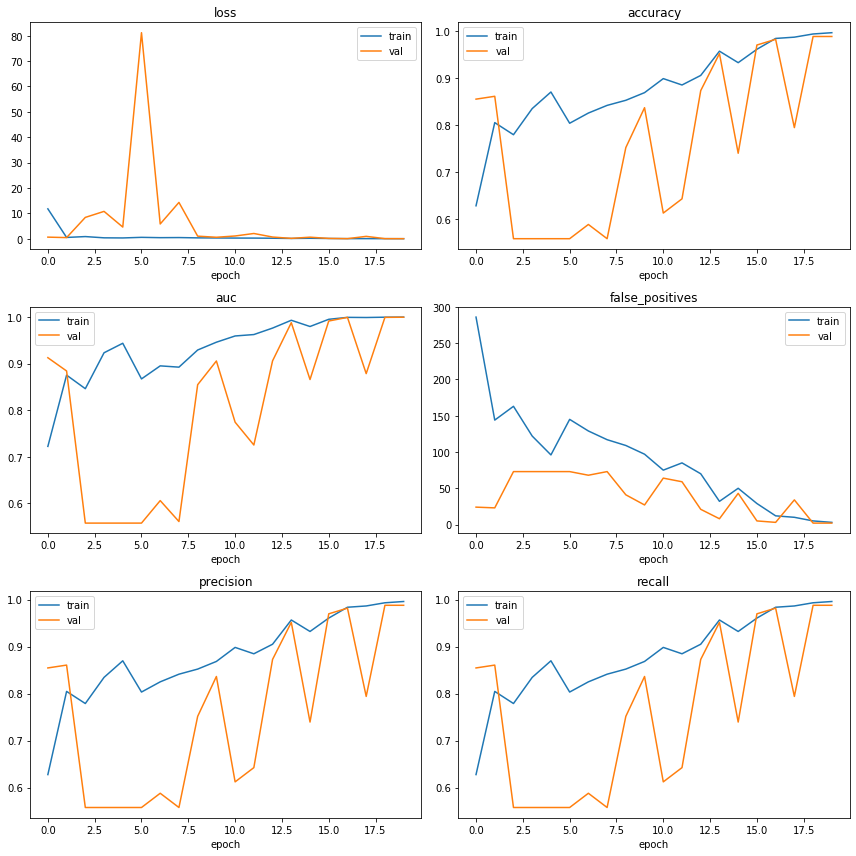

In [ ]:
def plot_history(hist):
    metrics = ['loss', 'accuracy', 'auc', 'false_positives', 'precision', 'recall']
    fig, axes = plt.subplots(3, 2, figsize=(12, 12))
    for idx, m in enumerate(metrics):
        ax = axes[idx // 2, idx % 2]
        ax.plot(hist.history[m], label='train')
        ax.plot(hist.history[f'val_{m}'], label='val')
        ax.set_title(m)
        ax.set_xlabel('epoch')
        ax.legend()
    plt.tight_layout()
    plt.show()

plot_history(history)

Model Validation

In [ ]:
val_metrics = model.evaluate(val_ds, verbose=1)
print("\nValidation set metrics:")
for name, value in zip(model.metrics_names, val_metrics):
    print(f" - {name}: {value:.4f}")

6/6 [==============================] - 11s 1s/step - loss: 0.0224 - accuracy: 0.9879 - auc: 0.9997 - false_positives: 2.0000 - precision: 0.9879 - recall: 0.9879

Validation set metrics:
 - loss: 0.0224
 - accuracy: 0.9879
 - auc: 0.9997
 - false_positives: 2.0000
 - precision: 0.9879
 - recall: 0.9879


Model Testing

In [ ]:
start = time.time()
preds = model.predict(test_ds)
print(f"\nInference time on test set: {time.time() - start:.2f}s")

y_true = np.argmax(np.vstack([y for _, y in test_ds.unbatch()]), axis=1)
y_pred = np.argmax(preds, axis=1)

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=classes))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
6/6 [==============================] - 23s 1s/step

Inference time on test set: 23.46s

Classification Report:

              precision    recall  f1-score   support

      benign       0.99      0.97      0.98        74
   malicious       0.98      0.99      0.98        91

    accuracy                           0.98       165
   macro avg       0.98      0.98      0.98     

Confusion Matrix

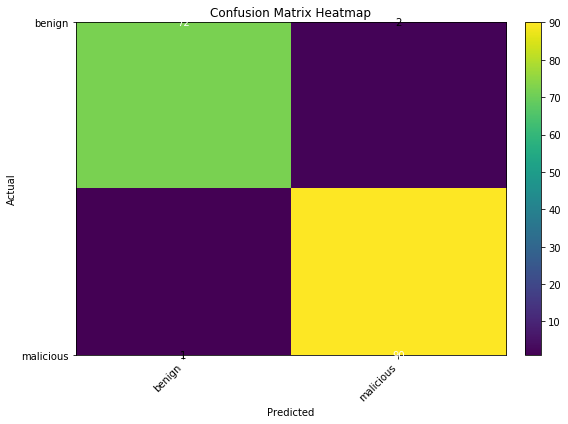

In [ ]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix Heatmap')
plt.imshow(cm, interpolation='nearest', aspect='auto')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.colorbar(fraction=0.046, pad=0.04)

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45, ha='right')
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, f"{cm[i, j]:d}",
             ha='center', va='center',
             color='white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.show()